## Wczytanie bibliotek

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.base import clone
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import numpy as np
import mlflow
from collections import Counter

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

## Wczytanie i przetworzenie danych
Poniższy kod nie będzie jakoś bardzo analizowany, ze względu na to, że w poprzednich notebookach ten kod był tworzony. W tym notebooku jedynie kod jest skopiowany, aby przygotowac dane do treningu różny modeli

In [2]:
df = pd.read_csv("https://pwozniak.kia.prz.edu.pl/files/uczeniemaszynowe/train_data.csv")
df.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,59,Arcanine,Fire,NaN,555,82,110,88,105,72,98,1,False
1,107,Hitmonchan,Fighting,NaN,455,47,97,84,27,121,79,1,False
2,123,Scyther,Bug,Flying,500,63,113,86,56,73,109,1,False
3,35,Clefairy,Fairy,NaN,323,67,54,46,58,62,36,1,False
4,150,MewtwoMega Mewtwo X,Psychic,Fighting,780,97,193,102,157,98,133,1,True


In [3]:
df_no_nans = df.fillna('Other')
df_no_nans.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,59,Arcanine,Fire,Other,555,82,110,88,105,72,98,1,False
1,107,Hitmonchan,Fighting,Other,455,47,97,84,27,121,79,1,False
2,123,Scyther,Bug,Flying,500,63,113,86,56,73,109,1,False
3,35,Clefairy,Fairy,Other,323,67,54,46,58,62,36,1,False
4,150,MewtwoMega Mewtwo X,Psychic,Fighting,780,97,193,102,157,98,133,1,True


In [4]:
df_clean = df_no_nans[(df_no_nans.HP > 0) & (df_no_nans.Attack > 0) & (df_no_nans.Defense > 0)].reset_index(drop=True)

columns = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
for column in columns:
    print(f"Wiersze w {column} które mają wartość poniżej lub równe 0: {len(df_clean[df_clean[column] <= 0])}")

Wiersze w Total które mają wartość poniżej lub równe 0: 0
Wiersze w HP które mają wartość poniżej lub równe 0: 0
Wiersze w Attack które mają wartość poniżej lub równe 0: 0
Wiersze w Defense które mają wartość poniżej lub równe 0: 0
Wiersze w Sp. Atk które mają wartość poniżej lub równe 0: 0
Wiersze w Sp. Def które mają wartość poniżej lub równe 0: 0
Wiersze w Speed które mają wartość poniżej lub równe 0: 0


In [5]:
label_enc = LabelEncoder()
df_cat = pd.DataFrame()
for column in ['Name', 'Type 1', 'Type 2']:
    df_cat[column] = label_enc.fit_transform(df_clean[column])

In [6]:
df_num = df_clean[['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']]
minmax_scaler = MinMaxScaler()
columns = df_num.columns
np_num = minmax_scaler.fit_transform(df_num)
df_num_norm = pd.DataFrame(np_num, columns=columns)
df_prepared = pd.concat([df_num_norm, df_cat, df_clean['Generation']], axis=1)

## Testowanie różnych modeli
W tej części będzie testowane 7 różnych modeli:
 - Adaboosting
 - Drzewa decyzyjne
 - Gradient boosting
 - Regresja logistycznya
 - KNN
 - SVM
 - Las losowy

Modele będą testowane na wykrywaniu imion pokemonów. Typy zostały pominięte.

In [25]:
def train(clf, X, y, model_name):
    with mlflow.start_run():
        mlflow.set_tags({"Model name" : model_name,})
        for cv in [5, 10, 20]:
            print(f"Cross validation k = {cv}")
            clf_t = clone(clf)
            cv_results = cross_validate(clf_t, X, y, scoring=("accuracy", "f1_macro"), cv=cv, n_jobs=-1)
            accuracy = np.round(np.mean(cv_results["test_accuracy"]), 3)
            f1_score = np.round(np.mean(cv_results["test_f1_macro"]), 3)
            mlflow.log_metric(f"Accuracy_{cv}", accuracy)
            mlflow.log_metric(f"F1_score_{cv}", f1_score)
            
            print(f"Accuracy: {accuracy}")
            print(f"F1-score: {f1_score}")

### Podział danych
Utworzenie zmiennych niezależnych (X) oraz zmiennej zależnej (y).

In [26]:
X = df_prepared[['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']]
y_pok = df_prepared.Name

### KNN

In [27]:
mlflow.set_experiment("Predict Pokemons Name")
knn = KNeighborsClassifier()
train(knn, X, y_pok, "KNN")

Cross validation k = 5
Accuracy: 0.921
F1-score: 0.919
Cross validation k = 10
Accuracy: 0.925
F1-score: 0.92
Cross validation k = 20
Accuracy: 0.923
F1-score: 0.903


C:\Users\urbii\Desktop\Projekty\Machine-learning-course\venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\urbii\Desktop\Projekty\Machine-learning-course\venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=20.
  warnings.warn(
2024/12/11 18:05:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run glamorous-horse-329 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/396a4414cceb4e89b90a17d72569e1e4.
2024/12/11 18:05:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Model KNN dobrze działa na tym zbiorze danych. Jego dodatkową zaletą jest duża szybkość. Walidację krzyżową dla trzech parametrów wykonał w około 266 ms.

### Logistyczna regresja

In [28]:
mlflow.set_experiment("Predict Pokemons Name")
clf_lr = LogisticRegression()
train(clf_lr, X, y_pok, "Logisitic regression")

Cross validation k = 5
Accuracy: 0.373
F1-score: 0.278
Cross validation k = 10


C:\Users\urbii\Desktop\Projekty\Machine-learning-course\venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


Accuracy: 0.398
F1-score: 0.297
Cross validation k = 20


C:\Users\urbii\Desktop\Projekty\Machine-learning-course\venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=20.
  warnings.warn(
2024/12/11 18:05:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run rare-skunk-48 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/0dc9db5cdfe748838e82695b9fdb7c4e.
2024/12/11 18:05:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.413
F1-score: 0.301


Logisyczna regresja najsłabiej radzi sobie z tymi zadaniami. Jak można zauważyć otrzymuje ostrzeżenie, że reprezentacja klasy jest mało liczebna (mamy wiele klas, ale mało przykładów na każdą klasę). Później postaram się to zmienić z pomocą augementacji danych.

### Las losowy

In [29]:
mlflow.set_experiment("Predict Pokemons Name")
clf_rf = RandomForestClassifier(random_state=42)
train(clf_rf, X, y_pok, "Random forest")

Cross validation k = 5
Accuracy: 0.978
F1-score: 0.977
Cross validation k = 10


C:\Users\urbii\Desktop\Projekty\Machine-learning-course\venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


Accuracy: 0.979
F1-score: 0.977
Cross validation k = 20


C:\Users\urbii\Desktop\Projekty\Machine-learning-course\venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=20.
  warnings.warn(
2024/12/11 18:07:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run victorious-yak-430 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/328ae44543a64d9b8971fe01d3c6cdd0.
2024/12/11 18:07:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.978
F1-score: 0.972


Jak można zauważyć las losowy uzyskuje doskonałem wyniki. Natomiast trzeba uważać, aby go nie przeuczyć. Modele oparte na architekturze drzewa mogą dość łatwo się nadmiernie dopasować.

### Drzewo decyzyjne

In [30]:
mlflow.set_experiment("Predict Pokemons Name")
clf_dt = DecisionTreeClassifier(random_state=42)
train(clf_dt, X, y_pok, "Decision tree")

Cross validation k = 5
Accuracy: 0.963
F1-score: 0.962
Cross validation k = 10


C:\Users\urbii\Desktop\Projekty\Machine-learning-course\venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\urbii\Desktop\Projekty\Machine-learning-course\venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=20.
  warnings.warn(


Accuracy: 0.964
F1-score: 0.961
Cross validation k = 20
Accuracy: 0.968
F1-score: 0.959


2024/12/11 18:09:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run bold-ray-287 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/553fb8a97f1e4d359597d865a1b0598f.
2024/12/11 18:09:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Drzewo decyzyjne dla zadania klasyfikacji nazw pokemonów wypada bardzo dobrze i osiąga podobne wyniki jak las losowy. Natomiast tutaj również tak jak w poprzedniej metodzie należy uważać na przeuczenie się modelu.

### SVM

In [31]:
mlflow.set_experiment("Predict Pokemons Name")
clf_svm = SVC()
train(clf_svm, X, y_pok, "SVM")

Cross validation k = 5
Accuracy: 0.927
F1-score: 0.925
Cross validation k = 10


C:\Users\urbii\Desktop\Projekty\Machine-learning-course\venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


Accuracy: 0.93
F1-score: 0.924
Cross validation k = 20


C:\Users\urbii\Desktop\Projekty\Machine-learning-course\venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=20.
  warnings.warn(
2024/12/11 18:11:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run clumsy-mule-997 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/0354ca0f8d1441209633c75dd3ab1333.
2024/12/11 18:11:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.929
F1-score: 0.91


SVM działa dośc dobrze, natomiast lekko odbiega od Lasu losowego i Drzewa decyzyjnego. Otrzymuje podobne wyniki co KNN, natomiast jest znacząco od niego wolniejszy (czas wykonywania około 2,8 s)

### Gradient boosting

In [32]:
mlflow.set_experiment("Predict Pokemons Name")
clf_gb = GradientBoostingClassifier(random_state=42)
train(clf_gb, X, y_pok, "Gradient boosting")

Cross validation k = 5
Accuracy: 0.844
F1-score: 0.842
Cross validation k = 10


C:\Users\urbii\Desktop\Projekty\Machine-learning-course\venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


Accuracy: 0.535
F1-score: 0.522
Cross validation k = 20


C:\Users\urbii\Desktop\Projekty\Machine-learning-course\venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=20.
  warnings.warn(
2024/12/11 18:19:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run dashing-dove-656 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/e026cd7aadd44ddf99e35363ce00e98b.
2024/12/11 18:19:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.506
F1-score: 0.476


Jak można zauważyć metoda gradient boosting nie najlepiej radzi sobie z danymi. Dodatkowo przez to jak ta metoda działa (tworzy drzewa, które muszą być wykonywane jeden po drugim), czas wykonania uczenia i weryfikacji jest bardzo długi (4 minuty).

### Adaboost

In [33]:
mlflow.set_experiment("Predict Pokemons Name")
clf_ab = AdaBoostClassifier(random_state=42)
train(clf_ab, X, y_pok, "Ada boosting")

Cross validation k = 5
Accuracy: 0.11
F1-score: 0.06
Cross validation k = 10


C:\Users\urbii\Desktop\Projekty\Machine-learning-course\venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


Accuracy: 0.106
F1-score: 0.067
Cross validation k = 20


C:\Users\urbii\Desktop\Projekty\Machine-learning-course\venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=20.
  warnings.warn(
2024/12/11 18:24:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run loud-grub-114 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/ff5201fc16044a9ea5aa1547834faf6b.
2024/12/11 18:24:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.041
F1-score: 0.024


Metoda adaboost kompletnie nie radzi sobie z tymi danymi. Natomiast jest zdecydowanie szybsza niż metoda Gradient boosting.

### Xgboost

In [34]:
mlflow.set_experiment("Predict Pokemons Name")
clf_xgb = xgb.XGBClassifier(random_state=42)
train(clf_xgb, X, y_pok, "Xgboost")

Cross validation k = 5
Accuracy: 0.951
F1-score: 0.949
Cross validation k = 10


C:\Users\urbii\Desktop\Projekty\Machine-learning-course\venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


Accuracy: 0.956
F1-score: 0.952
Cross validation k = 20


C:\Users\urbii\Desktop\Projekty\Machine-learning-course\venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=20.
  warnings.warn(
2024/12/11 18:27:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run beautiful-yak-325 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/e1d02f074a67470b8c2dd5b5941404c0.
2024/12/11 18:27:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.956
F1-score: 0.942


Model xgboost jest porównywalny do lasów losowych i drzew decyzyjnych. Podczas eksperymentów wynik wskazał na to, że las losowy jest najlepszym modelem. Natomiast drzewa decyzyjne były drugie. Średni wynik dla 5-krotnej walidacji krzyżowej dla lasów losowych wyniósł 97,8%, natomiast dla drzew decyzyjnych wyniósł 96,3%. Drzewa decyzyjne są szybsze niż lasy losowe. Przy walidacji krzyżowej praktycznie każdy model otrzymywał najlepsze wyniki dla walidacji 5-krotnej i 10-krotnej. Przy walidacji 20-krotnej te wyniki nieznacznie spadały. Może to wynikać z dość dużej liczby klas i nie wystarczającej liczby przykładów.

## Augmentacja danych

Jak można zauważyc każda z klas zawiera po 20 przykładów, co w sumie jest dośc małą ilością. W tej części postaram się zwiększyć ilość próbek. Zostanie do tego wykorzystana klasa SMOTE. Jest to metoda synentic minority oversampling technique, która ma na celu dodawać do zbioru danych dodatkowe próbki dla klasy mniejszościowej. Natomiast można wymusić augmentację danych.

In [73]:
def train_aug(clf, X, y, model_name, n_samples, k_neighbors):
    with mlflow.start_run():
        mlflow.set_tags({"Model name" : model_name, "Augmentation" : "True"})
        for cv in [5, 10, 20]:
            print(f"Cross validation k = {cv}")
            mlflow.log_params({"n_samples" : n_samples, "k_neighbors" : k_neighbors})
            clf_t = clone(clf)
            cv_results = cross_validate(clf_t, X, y, scoring=("accuracy", "f1_macro"), cv=cv, n_jobs=-1)
            accuracy = np.round(np.mean(cv_results["test_accuracy"]), 3)
            f1_score = np.round(np.mean(cv_results["test_f1_macro"]), 3)
            mlflow.log_metric(f"Accuracy_{cv}", accuracy)
            mlflow.log_metric(f"F1_score_{cv}", f1_score)
            
            print(f"Accuracy: {accuracy}")
            print(f"F1-score: {f1_score}")


def plot_confusion_matrix(clf, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    plt.figure(figsize=(12,12))
    plt.title("Macierz pomyłek")
    sns.heatmap(confusion_matrix(y_pred = y_pred,y_true= y_test))
    plt.show()

In [7]:
X = df_prepared[['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']]
y_pok = df_prepared.Name
Counter(y_pok)

Counter({6: 20,
         60: 20,
         133: 20,
         23: 20,
         92: 20,
         53: 20,
         160: 20,
         83: 20,
         164: 20,
         145: 20,
         46: 20,
         99: 20,
         15: 20,
         150: 20,
         18: 20,
         36: 20,
         82: 20,
         109: 20,
         108: 20,
         91: 20,
         30: 20,
         89: 20,
         78: 20,
         81: 20,
         161: 20,
         38: 20,
         152: 20,
         75: 20,
         1: 20,
         153: 20,
         70: 20,
         14: 20,
         120: 20,
         155: 20,
         149: 20,
         68: 20,
         111: 20,
         95: 20,
         104: 20,
         28: 20,
         162: 20,
         64: 20,
         128: 20,
         143: 20,
         139: 20,
         48: 20,
         19: 20,
         11: 20,
         31: 20,
         3: 20,
         5: 20,
         41: 20,
         121: 20,
         90: 20,
         138: 20,
         57: 20,
         67: 20,
         102: 

### Augmentacja do 30 przykładów

In [8]:
sampling_strat = {i: 30 for i in range(min(Counter(y_pok).keys()), max(Counter(y_pok).keys()) + 1)}
smote = SMOTE(sampling_strategy=sampling_strat, random_state=42)
X_res, y_res = smote.fit_resample(X, y_pok)
Counter(y_res)

Counter({6: 30,
         60: 30,
         133: 30,
         23: 30,
         92: 30,
         53: 30,
         160: 30,
         83: 30,
         164: 30,
         145: 30,
         46: 30,
         99: 30,
         15: 30,
         150: 30,
         18: 30,
         36: 30,
         82: 30,
         109: 30,
         108: 30,
         91: 30,
         30: 30,
         89: 30,
         78: 30,
         81: 30,
         161: 30,
         38: 30,
         152: 30,
         75: 30,
         1: 30,
         153: 30,
         70: 30,
         14: 30,
         120: 30,
         155: 30,
         149: 30,
         68: 30,
         111: 30,
         95: 30,
         104: 30,
         28: 30,
         162: 30,
         64: 30,
         128: 30,
         143: 30,
         139: 30,
         48: 30,
         19: 30,
         11: 30,
         31: 30,
         3: 30,
         5: 30,
         41: 30,
         121: 30,
         90: 30,
         138: 30,
         57: 30,
         67: 30,
         102: 

In [96]:
abs(X.describe() - X_res.describe())

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
count,1672.000000,1672.000000,1672.000000,1672.000000,1672.000000,1672.000000,1672.000000
mean,0.000048,0.002476,0.001375,0.001267,0.000481,0.000778,0.000619
std,0.000296,0.007986,0.001141,0.000789,0.000064,0.000052,0.000516
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.004364,0.000000,0.000000,0.000000
50%,0.002564,0.000011,0.000256,0.002263,0.001959,0.000000,0.000000
75%,0.000000,0.002953,0.000000,0.000000,0.000000,0.004354,0.002719
max,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


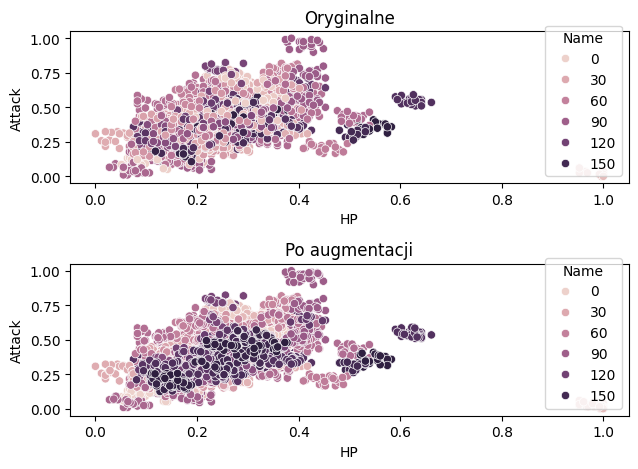

In [97]:
plt.subplot(2, 1, 1)
plt.title('Oryginalne')
sns.scatterplot(data=X, x='HP', y='Attack', hue=y_pok)
plt.subplot(2, 1, 2)
plt.title('Po augmentacji')
sns.scatterplot(data=X_res, x='HP', y='Attack', hue=y_res)
plt.tight_layout()
plt.show()

In [98]:
clf = RandomForestClassifier(random_state=42)
for k in [3, 4, 5, 6, 7, 8]:
    print(f"Trening dla k: {k}")
    smote = SMOTE(sampling_strategy=sampling_strat, k_neighbors=k, random_state=42)
    X_res, y_res = smote.fit_resample(X, y_pok)
    train_aug(clf, X_res, y_res, "Random forest", 30, k)

Trening dla k: 3
Cross validation k = 5
Accuracy: 0.989
F1-score: 0.989
Cross validation k = 10
Accuracy: 0.989
F1-score: 0.989
Cross validation k = 20


2024/12/11 20:18:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run adorable-shark-287 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/371f81f06c1942fd92d54c7a4b0d05f0.
2024/12/11 20:18:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.99
F1-score: 0.989
Trening dla k: 4
Cross validation k = 5
Accuracy: 0.987
F1-score: 0.987
Cross validation k = 10
Accuracy: 0.989
F1-score: 0.989
Cross validation k = 20


2024/12/11 20:19:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run salty-jay-637 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/f6d9d696add14f8d9947acba2240ea66.
2024/12/11 20:19:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.99
F1-score: 0.988
Trening dla k: 5
Cross validation k = 5
Accuracy: 0.989
F1-score: 0.988
Cross validation k = 10
Accuracy: 0.988
F1-score: 0.988
Cross validation k = 20


2024/12/11 20:19:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run crawling-ox-751 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/a3e2249cd4dd47bda204d72ac4cf0c98.
2024/12/11 20:19:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.987
F1-score: 0.985
Trening dla k: 6
Cross validation k = 5
Accuracy: 0.99
F1-score: 0.989
Cross validation k = 10
Accuracy: 0.989
F1-score: 0.989
Cross validation k = 20


2024/12/11 20:19:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run illustrious-shad-267 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/36b04ba82b4f422d9fd6eadbf70bec6e.
2024/12/11 20:19:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.989
F1-score: 0.988
Trening dla k: 7
Cross validation k = 5
Accuracy: 0.988
F1-score: 0.988
Cross validation k = 10
Accuracy: 0.99
F1-score: 0.99
Cross validation k = 20


2024/12/11 20:19:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run brawny-shrew-320 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/b0cae987894c4fe08bc567b1901b45b9.
2024/12/11 20:19:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.989
F1-score: 0.988
Trening dla k: 8
Cross validation k = 5
Accuracy: 0.987
F1-score: 0.987
Cross validation k = 10
Accuracy: 0.988
F1-score: 0.987
Cross validation k = 20


2024/12/11 20:19:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run bustling-sow-572 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/00aba40501c64d99a5ed873cd92f2cb0.
2024/12/11 20:19:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.988
F1-score: 0.986


In [99]:
clf = DecisionTreeClassifier(random_state=42)
for k in [3, 4, 5, 6, 7, 8]:
    print(f"Trening dla k: {k}")
    smote = SMOTE(sampling_strategy=sampling_strat, k_neighbors=k, random_state=42)
    X_res, y_res = smote.fit_resample(X, y_pok)
    train_aug(clf, X_res, y_res, "Decision tree", 30, k)

Trening dla k: 3
Cross validation k = 5
Accuracy: 0.977
F1-score: 0.976
Cross validation k = 10
Accuracy: 0.976
F1-score: 0.975
Cross validation k = 20


2024/12/11 20:20:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run victorious-mare-838 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/704edf504e2b44ea8b358c2482680909.
2024/12/11 20:20:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.975
F1-score: 0.971
Trening dla k: 4
Cross validation k = 5
Accuracy: 0.976
F1-score: 0.976
Cross validation k = 10
Accuracy: 0.98
F1-score: 0.979
Cross validation k = 20


2024/12/11 20:20:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run persistent-wasp-926 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/91a38f4c1a0947f395fcb6581aecf2d4.
2024/12/11 20:20:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.978
F1-score: 0.974
Trening dla k: 5
Cross validation k = 5
Accuracy: 0.976
F1-score: 0.976
Cross validation k = 10
Accuracy: 0.976
F1-score: 0.975
Cross validation k = 20


2024/12/11 20:20:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run unique-moth-500 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/a0ed679efa1b474787fbd45257fd9ca9.
2024/12/11 20:20:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.973
F1-score: 0.969
Trening dla k: 6
Cross validation k = 5
Accuracy: 0.98
F1-score: 0.979
Cross validation k = 10
Accuracy: 0.979
F1-score: 0.978
Cross validation k = 20


2024/12/11 20:20:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run hilarious-carp-75 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/d71778800359448cb402e71871bf2be3.
2024/12/11 20:20:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.976
F1-score: 0.973
Trening dla k: 7
Cross validation k = 5
Accuracy: 0.977
F1-score: 0.976
Cross validation k = 10
Accuracy: 0.979
F1-score: 0.978
Cross validation k = 20


2024/12/11 20:20:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run upbeat-ram-682 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/ebc815e3e7f34b988700eb9666397d9b.
2024/12/11 20:20:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.976
F1-score: 0.972
Trening dla k: 8
Cross validation k = 5
Accuracy: 0.978
F1-score: 0.978
Cross validation k = 10
Accuracy: 0.98
F1-score: 0.979
Cross validation k = 20


2024/12/11 20:20:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run trusting-eel-530 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/ecb85e55591e481087417a7cd029d916.
2024/12/11 20:20:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.976
F1-score: 0.972


Jak można zauważyć augmentacja danych pozwoliła zwiększyć dokładność modeli (nie wielki wzrost). Prezentowane metryki były obliczane dla walidacji 10-krotnej. Nie ma znaczącących różnić w doborze parametru, chociaż pewne wachania są zauważalne. Dla lasu losowego najlepszy parametr smote przyjął wartość 6, natomiast dla drzewa decyzyjnego było to 8. Nadal las losowy lepiej sobie radzi z tymi danymi.

Wyniki dla lasu losowego:

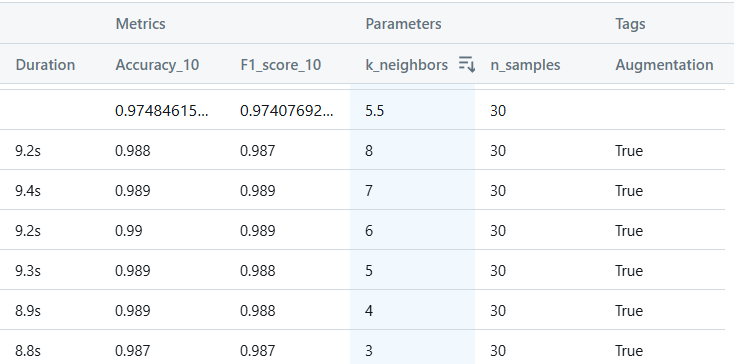

Wyniki dla drzewa decyzyjnego:

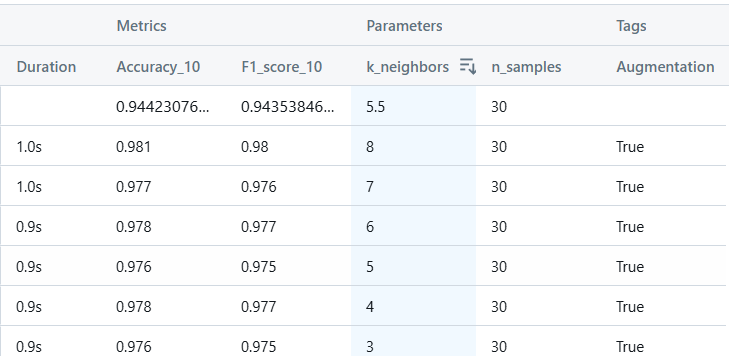

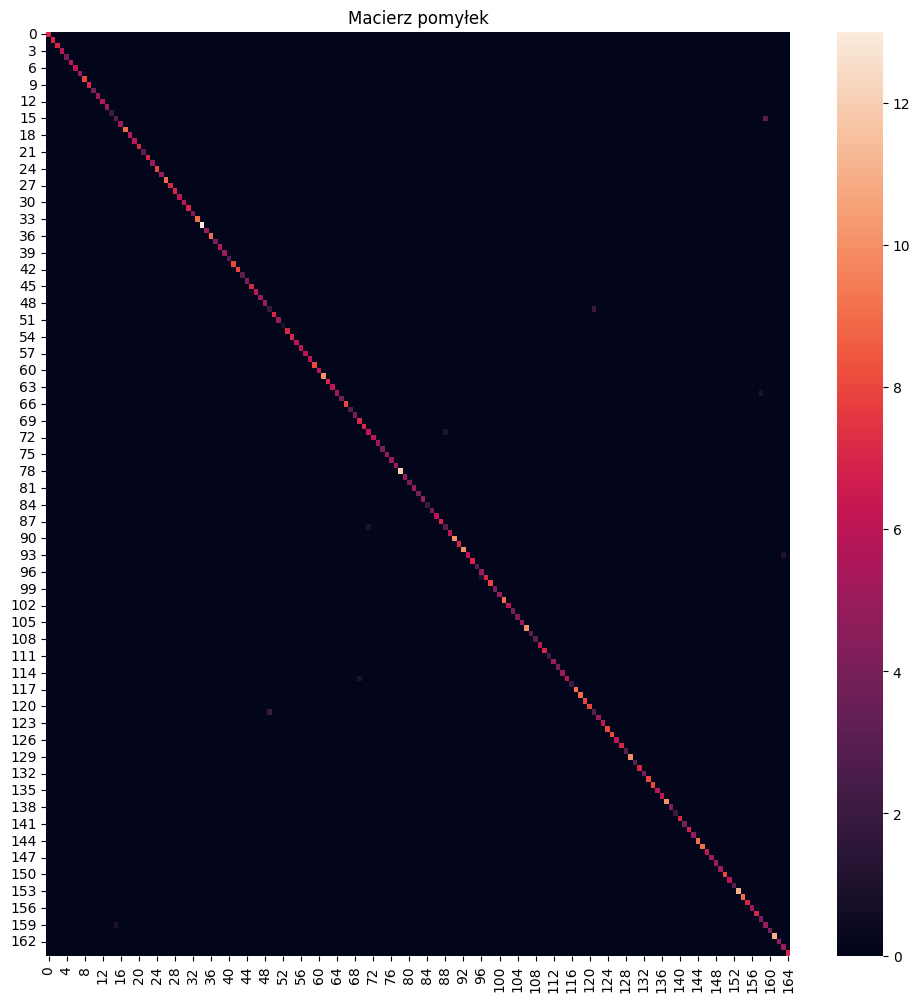

In [102]:
clf = RandomForestClassifier(random_state=42)
plot_confusion_matrix(clf, X_res, y_res)

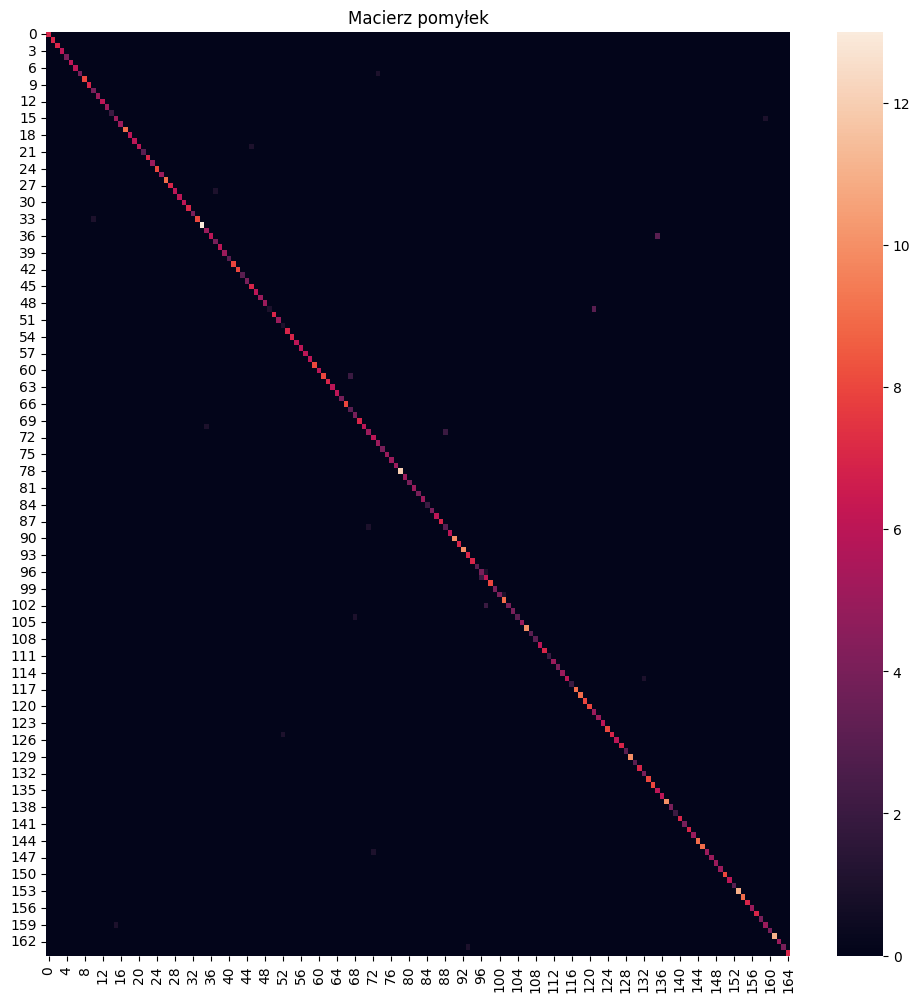

In [103]:
clf = RandomForestClassifier(random_state=42)
plot_confusion_matrix(clf, X_res, y_res)

### Augmentacja do 40 przykładów

In [107]:
sampling_strat = {i: 40 for i in range(min(Counter(y_pok).keys()), max(Counter(y_pok).keys()) + 1)}
smote = SMOTE(sampling_strategy=sampling_strat, random_state=42)
X_res, y_res = smote.fit_resample(X, y_pok)
Counter(y_res)

Counter({6: 40,
         60: 40,
         133: 40,
         23: 40,
         92: 40,
         53: 40,
         160: 40,
         83: 40,
         164: 40,
         145: 40,
         46: 40,
         99: 40,
         15: 40,
         150: 40,
         18: 40,
         36: 40,
         82: 40,
         109: 40,
         108: 40,
         91: 40,
         30: 40,
         89: 40,
         78: 40,
         81: 40,
         161: 40,
         38: 40,
         152: 40,
         75: 40,
         1: 40,
         153: 40,
         70: 40,
         14: 40,
         120: 40,
         155: 40,
         149: 40,
         68: 40,
         111: 40,
         95: 40,
         104: 40,
         28: 40,
         162: 40,
         64: 40,
         128: 40,
         143: 40,
         139: 40,
         48: 40,
         19: 40,
         11: 40,
         31: 40,
         3: 40,
         5: 40,
         41: 40,
         121: 40,
         90: 40,
         138: 40,
         57: 40,
         67: 40,
         102: 

In [105]:
abs(X.describe() - X_res.describe())

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
count,3332.000000,3332.000000,3332.000000,3332.000000,3332.000000,3332.000000,3332.000000
mean,0.000048,0.002310,0.001359,0.001270,0.000411,0.000760,0.000439
std,0.000301,0.007726,0.000823,0.000793,0.000042,0.000113,0.000705
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.004679,0.000000,0.000000,0.000196
50%,0.002564,0.000232,0.000089,0.002674,0.000896,0.000000,0.000000
75%,0.000000,0.002747,0.000287,0.000505,0.000000,0.003701,0.003907
max,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


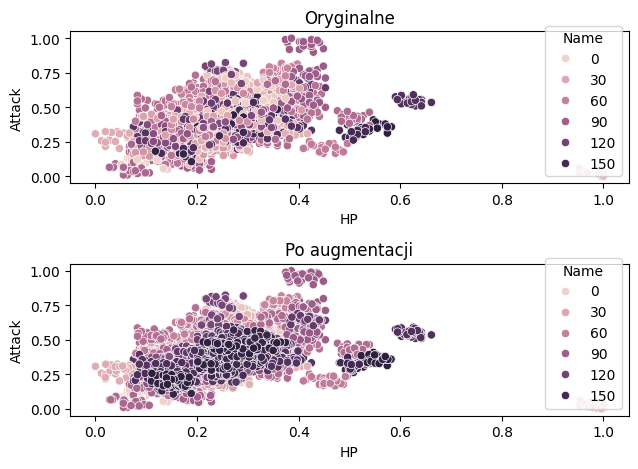

In [106]:
plt.subplot(2, 1, 1)
plt.title('Oryginalne')
sns.scatterplot(data=X, x='HP', y='Attack', hue=y_pok)
plt.subplot(2, 1, 2)
plt.title('Po augmentacji')
sns.scatterplot(data=X_res, x='HP', y='Attack', hue=y_res)
plt.tight_layout()
plt.show()

In [108]:
clf = RandomForestClassifier(random_state=42)
for k in [3, 4, 5, 6, 7, 8]:
    print(f"Trening dla k: {k}")
    smote = SMOTE(sampling_strategy=sampling_strat, k_neighbors=k, random_state=42)
    X_res, y_res = smote.fit_resample(X, y_pok)
    train_aug(clf, X_res, y_res, "Random forest", 40, k)

Trening dla k: 3
Cross validation k = 5
Accuracy: 0.994
F1-score: 0.994
Cross validation k = 10
Accuracy: 0.993
F1-score: 0.993
Cross validation k = 20


2024/12/11 20:29:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run salty-quail-165 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/db85f1f00d134cd5a6b1d57c9f4a1f4e.
2024/12/11 20:29:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.993
F1-score: 0.993
Trening dla k: 4
Cross validation k = 5
Accuracy: 0.993
F1-score: 0.993
Cross validation k = 10
Accuracy: 0.994
F1-score: 0.993
Cross validation k = 20


2024/12/11 20:29:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run dashing-lamb-909 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/fb8f3a02143a4dfcb8c3fe7d35842c56.
2024/12/11 20:29:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.993
F1-score: 0.992
Trening dla k: 5
Cross validation k = 5
Accuracy: 0.993
F1-score: 0.993
Cross validation k = 10
Accuracy: 0.993
F1-score: 0.993
Cross validation k = 20


2024/12/11 20:30:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run rebellious-cat-663 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/8ade1a22d5ee4b6b83fdf9e2b61ae22f.
2024/12/11 20:30:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.992
F1-score: 0.992
Trening dla k: 6
Cross validation k = 5
Accuracy: 0.993
F1-score: 0.993
Cross validation k = 10
Accuracy: 0.994
F1-score: 0.993
Cross validation k = 20


2024/12/11 20:30:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run beautiful-wolf-113 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/41ab522c6c594381a912c04aee9302ac.
2024/12/11 20:30:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.994
F1-score: 0.993
Trening dla k: 7
Cross validation k = 5
Accuracy: 0.994
F1-score: 0.994
Cross validation k = 10
Accuracy: 0.993
F1-score: 0.993
Cross validation k = 20


2024/12/11 20:30:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run sneaky-kit-483 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/f604ab3cf0f9499fbefc36d0dcb90c18.
2024/12/11 20:30:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.994
F1-score: 0.993
Trening dla k: 8
Cross validation k = 5
Accuracy: 0.991
F1-score: 0.991
Cross validation k = 10
Accuracy: 0.991
F1-score: 0.991
Cross validation k = 20


2024/12/11 20:30:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run luxuriant-mink-693 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/b86b11964cb2447e99db3fd52403176f.
2024/12/11 20:30:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.991
F1-score: 0.99


In [109]:
clf = DecisionTreeClassifier(random_state=42)
for k in [3, 4, 5, 6, 7, 8]:
    print(f"Trening dla k: {k}")
    smote = SMOTE(sampling_strategy=sampling_strat, k_neighbors=k, random_state=42)
    X_res, y_res = smote.fit_resample(X, y_pok)
    train_aug(clf, X_res, y_res, "Decision tree", 40, k)

Trening dla k: 3
Cross validation k = 5
Accuracy: 0.984
F1-score: 0.984
Cross validation k = 10
Accuracy: 0.986
F1-score: 0.986
Cross validation k = 20


2024/12/11 20:30:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run salty-lynx-902 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/8ac662f1742d4b71a1066ff35eb41970.
2024/12/11 20:30:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.986
F1-score: 0.985
Trening dla k: 4
Cross validation k = 5
Accuracy: 0.984
F1-score: 0.984
Cross validation k = 10
Accuracy: 0.986
F1-score: 0.986
Cross validation k = 20


2024/12/11 20:30:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run powerful-stork-694 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/3f082cc2e459457fa38061e43385282b.
2024/12/11 20:30:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.987
F1-score: 0.986
Trening dla k: 5
Cross validation k = 5
Accuracy: 0.986
F1-score: 0.986
Cross validation k = 10
Accuracy: 0.985
F1-score: 0.985
Cross validation k = 20


2024/12/11 20:30:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run blushing-rat-293 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/acdb9aa607e1415d8b91fd852b8bcc36.
2024/12/11 20:30:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.985
F1-score: 0.984
Trening dla k: 6
Cross validation k = 5
Accuracy: 0.983
F1-score: 0.983
Cross validation k = 10
Accuracy: 0.985
F1-score: 0.985
Cross validation k = 20


2024/12/11 20:31:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run abrasive-deer-327 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/6a2b55a92023439b8c996f36a01bb02b.
2024/12/11 20:31:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.985
F1-score: 0.984
Trening dla k: 7
Cross validation k = 5
Accuracy: 0.985
F1-score: 0.985
Cross validation k = 10
Accuracy: 0.986
F1-score: 0.986
Cross validation k = 20


2024/12/11 20:31:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run suave-koi-295 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/fb0426ff361d482d87d65eb4941c2a8b.
2024/12/11 20:31:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.987
F1-score: 0.986
Trening dla k: 8
Cross validation k = 5
Accuracy: 0.982
F1-score: 0.982
Cross validation k = 10
Accuracy: 0.982
F1-score: 0.982
Cross validation k = 20


2024/12/11 20:31:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run enchanting-eel-440 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/1479d55a0e564953a9baaea0dec55d47.
2024/12/11 20:31:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.984
F1-score: 0.983


Podwojenie danych zwiększyło dokładność obydwu modeli. Trzeba być uważnym ponieważ model może być przetrenowany. Dla drzewa decyzyjnego wzrost był największy dla k równego 5, bo wtedy dokładność wzrosła o około 1 %. Przy lasach losowych również dokładność wzrosła, natomiast nie były to aż tak duże zmiany. Wystąpiły zmiany około 0,5 %, natomiast trzeba pamiętać, że dla tego zbioru dochodzimy do prawie 100% dokładności.

Wyniki dla drzewa decyzyjnego:

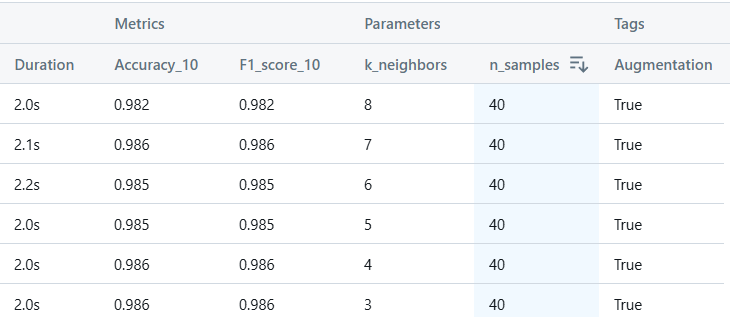

Wyniki dla lasu losowego:

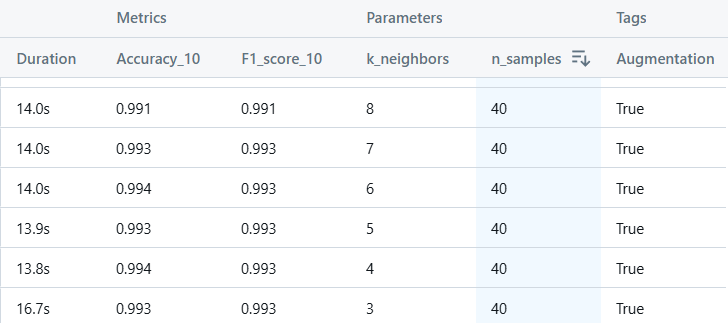

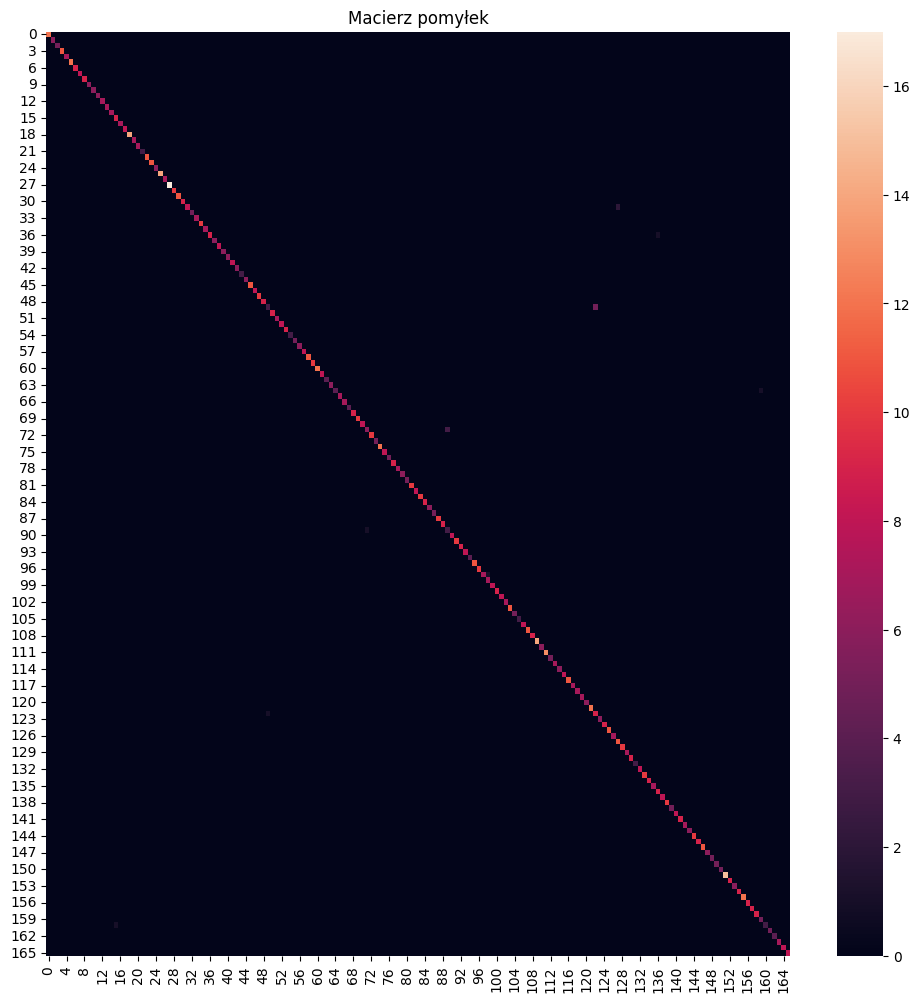

In [110]:
clf = RandomForestClassifier(random_state=42)
plot_confusion_matrix(clf, X_res, y_res)

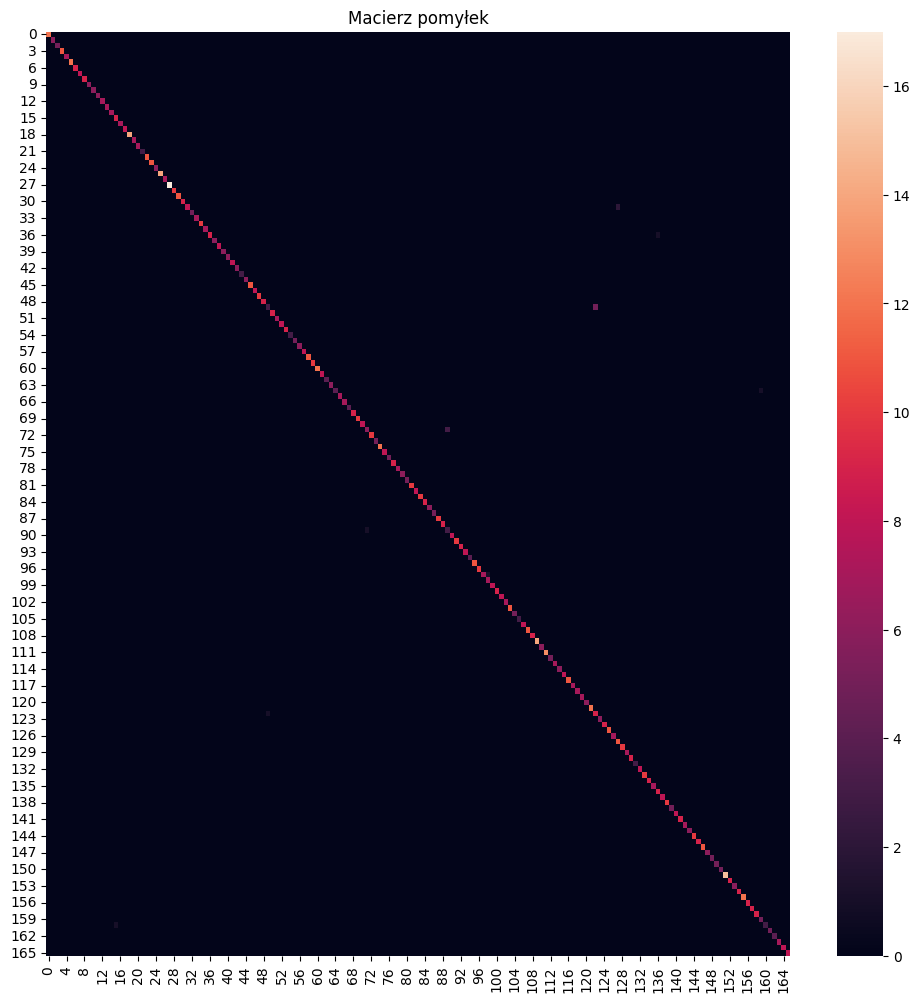

In [111]:
clf = RandomForestClassifier(random_state=42)
plot_confusion_matrix(clf, X_res, y_res)

### Augmentacja do 50 przykładów

In [120]:
sampling_strat = {i: 50 for i in range(min(Counter(y_pok).keys()), max(Counter(y_pok).keys()) + 1)}
smote = SMOTE(sampling_strategy=sampling_strat, random_state=42)
X_res, y_res = smote.fit_resample(X, y_pok)
Counter(y_res)

Counter({6: 50,
         60: 50,
         133: 50,
         23: 50,
         92: 50,
         53: 50,
         160: 50,
         83: 50,
         164: 50,
         145: 50,
         46: 50,
         99: 50,
         15: 50,
         150: 50,
         18: 50,
         36: 50,
         82: 50,
         109: 50,
         108: 50,
         91: 50,
         30: 50,
         89: 50,
         78: 50,
         81: 50,
         161: 50,
         38: 50,
         152: 50,
         75: 50,
         1: 50,
         153: 50,
         70: 50,
         14: 50,
         120: 50,
         155: 50,
         149: 50,
         68: 50,
         111: 50,
         95: 50,
         104: 50,
         28: 50,
         162: 50,
         64: 50,
         128: 50,
         143: 50,
         139: 50,
         48: 50,
         19: 50,
         11: 50,
         31: 50,
         3: 50,
         5: 50,
         41: 50,
         121: 50,
         90: 50,
         138: 50,
         57: 50,
         67: 50,
         102: 

In [121]:
abs(X.describe() - X_res.describe())

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
count,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000,4992.000000
mean,0.000048,0.002262,0.001050,0.001276,0.000589,0.000771,0.000531
std,0.000304,0.007649,0.000599,0.000686,0.000233,0.000089,0.000795
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.003504,0.000000,0.001059,0.000244
50%,0.002564,0.000000,0.000000,0.002636,0.000855,0.000000,0.000000
75%,0.000000,0.002681,0.000473,0.000000,0.000000,0.003374,0.002178
max,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


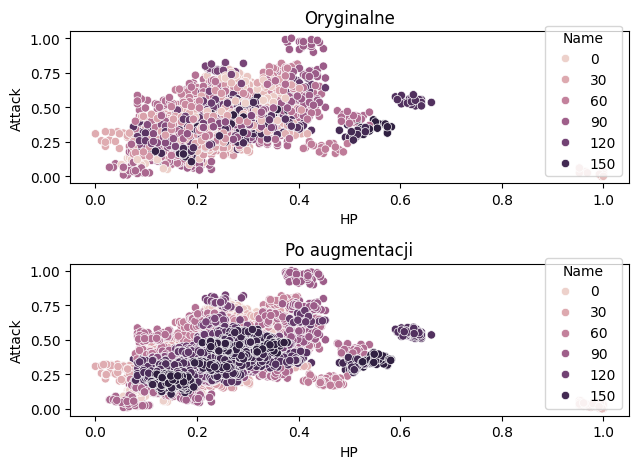

In [122]:
plt.subplot(2, 1, 1)
plt.title('Oryginalne')
sns.scatterplot(data=X, x='HP', y='Attack', hue=y_pok)
plt.subplot(2, 1, 2)
plt.title('Po augmentacji')
sns.scatterplot(data=X_res, x='HP', y='Attack', hue=y_res)
plt.tight_layout()
plt.show()

In [116]:
clf = RandomForestClassifier(random_state=42)
for k in [3, 4, 5, 6, 7, 8]:
    print(f"Trening dla k: {k}")
    smote = SMOTE(sampling_strategy=sampling_strat, k_neighbors=k, random_state=42)
    X_res, y_res = smote.fit_resample(X, y_pok)
    train_aug(clf, X_res, y_res, "Random forest", 50, k)

Trening dla k: 3
Cross validation k = 5
Accuracy: 0.994
F1-score: 0.994
Cross validation k = 10
Accuracy: 0.994
F1-score: 0.994
Cross validation k = 20


2024/12/11 20:35:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run masked-fox-277 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/336e6969093a45bb864e0f9743d7404b.
2024/12/11 20:35:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.994
F1-score: 0.994
Trening dla k: 4
Cross validation k = 5
Accuracy: 0.994
F1-score: 0.994
Cross validation k = 10
Accuracy: 0.994
F1-score: 0.994
Cross validation k = 20


2024/12/11 20:35:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run zealous-sheep-897 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/01418096ce1f4c629d1e5f5417ffe0a6.
2024/12/11 20:35:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.995
F1-score: 0.994
Trening dla k: 5
Cross validation k = 5
Accuracy: 0.995
F1-score: 0.995
Cross validation k = 10
Accuracy: 0.995
F1-score: 0.995
Cross validation k = 20


2024/12/11 20:35:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run fearless-hog-680 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/4ae409c3a1064fd19e703eecf16cc34b.
2024/12/11 20:35:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.995
F1-score: 0.995
Trening dla k: 6
Cross validation k = 5
Accuracy: 0.995
F1-score: 0.995
Cross validation k = 10
Accuracy: 0.995
F1-score: 0.995
Cross validation k = 20


2024/12/11 20:36:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run adventurous-lynx-517 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/88525e8292f3409db14a1ac2b13dc1c5.
2024/12/11 20:36:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.995
F1-score: 0.995
Trening dla k: 7
Cross validation k = 5
Accuracy: 0.994
F1-score: 0.994
Cross validation k = 10
Accuracy: 0.994
F1-score: 0.994
Cross validation k = 20


2024/12/11 20:36:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run trusting-goat-739 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/5f61ba582ffd42fba3a488d8f7f0fc34.
2024/12/11 20:36:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.994
F1-score: 0.993
Trening dla k: 8
Cross validation k = 5
Accuracy: 0.994
F1-score: 0.994
Cross validation k = 10
Accuracy: 0.993
F1-score: 0.993
Cross validation k = 20


2024/12/11 20:36:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run casual-roo-645 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/2e01f898f3fd4bfea29c5de9dff629c0.
2024/12/11 20:36:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.994
F1-score: 0.994


In [117]:
clf = DecisionTreeClassifier(random_state=42)
for k in [3, 4, 5, 6, 7, 8]:
    print(f"Trening dla k: {k}")
    smote = SMOTE(sampling_strategy=sampling_strat, k_neighbors=k, random_state=42)
    X_res, y_res = smote.fit_resample(X, y_pok)
    train_aug(clf, X_res, y_res, "Decision tree", 50, k)

Trening dla k: 3
Cross validation k = 5
Accuracy: 0.987
F1-score: 0.987
Cross validation k = 10
Accuracy: 0.988
F1-score: 0.988
Cross validation k = 20


2024/12/11 20:36:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run loud-lamb-279 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/95f9a4271ec44c968b5a2711e248220e.
2024/12/11 20:36:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.989
F1-score: 0.988
Trening dla k: 4
Cross validation k = 5
Accuracy: 0.988
F1-score: 0.988
Cross validation k = 10
Accuracy: 0.989
F1-score: 0.989
Cross validation k = 20


2024/12/11 20:36:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run awesome-grub-681 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/2eed0b2edc004bcaa37dda72b9d94168.
2024/12/11 20:36:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.987
F1-score: 0.986
Trening dla k: 5
Cross validation k = 5
Accuracy: 0.989
F1-score: 0.989
Cross validation k = 10
Accuracy: 0.988
F1-score: 0.988
Cross validation k = 20


2024/12/11 20:36:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run wistful-shrimp-602 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/8e2d3b7527e541ac934b0848827b965e.
2024/12/11 20:36:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.987
F1-score: 0.986
Trening dla k: 6
Cross validation k = 5
Accuracy: 0.987
F1-score: 0.987
Cross validation k = 10
Accuracy: 0.987
F1-score: 0.987
Cross validation k = 20


2024/12/11 20:36:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run redolent-hawk-319 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/7f6ffc9d21b3413b9447d69b729c5070.
2024/12/11 20:36:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.988
F1-score: 0.986
Trening dla k: 7
Cross validation k = 5
Accuracy: 0.987
F1-score: 0.987
Cross validation k = 10
Accuracy: 0.987
F1-score: 0.986
Cross validation k = 20


2024/12/11 20:36:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run legendary-worm-300 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/756d966938fe417ba37d7b697f80a03a.
2024/12/11 20:36:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.987
F1-score: 0.986
Trening dla k: 8
Cross validation k = 5
Accuracy: 0.987
F1-score: 0.987
Cross validation k = 10
Accuracy: 0.989
F1-score: 0.988
Cross validation k = 20


2024/12/11 20:36:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run enchanting-auk-591 at: http://127.0.0.1:8080/#/experiments/479905616626895318/runs/ea4207b1bd1349a98989e7825b94c61c.
2024/12/11 20:36:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/479905616626895318.


Accuracy: 0.987
F1-score: 0.985


Ze większeniem ilości próbek do 50, różnica pomiędzy wcześniejszymi wynikami jest znikoma. Można zauważyć wzrost około 0.2/0.1 % dla jednego i drugiego modelu.

Wyniki dla drzewa decyzyjnego:

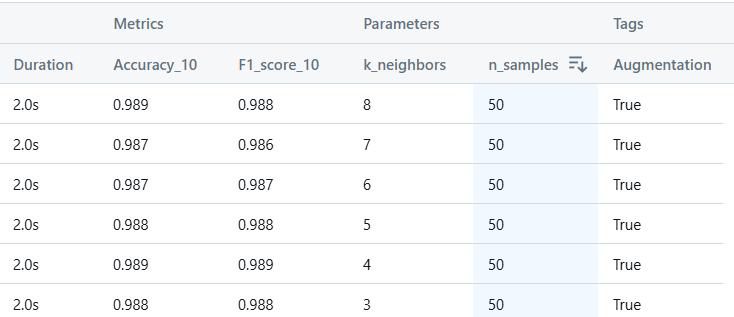


Wyniki dla lasu losowego:

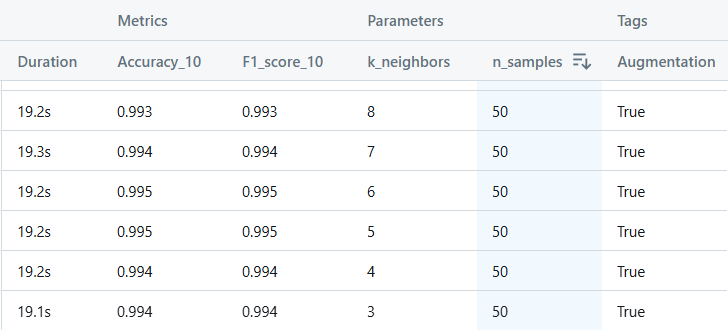

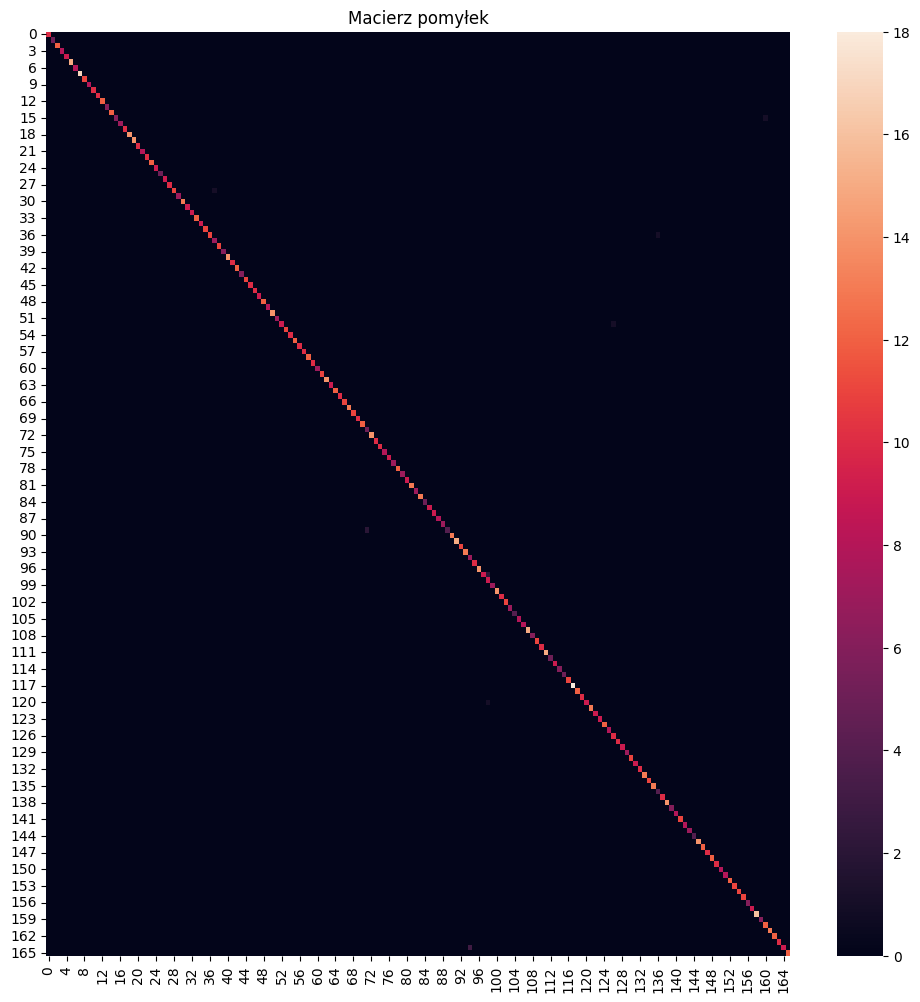

In [118]:
clf = RandomForestClassifier(random_state=42)
plot_confusion_matrix(clf, X_res, y_res)

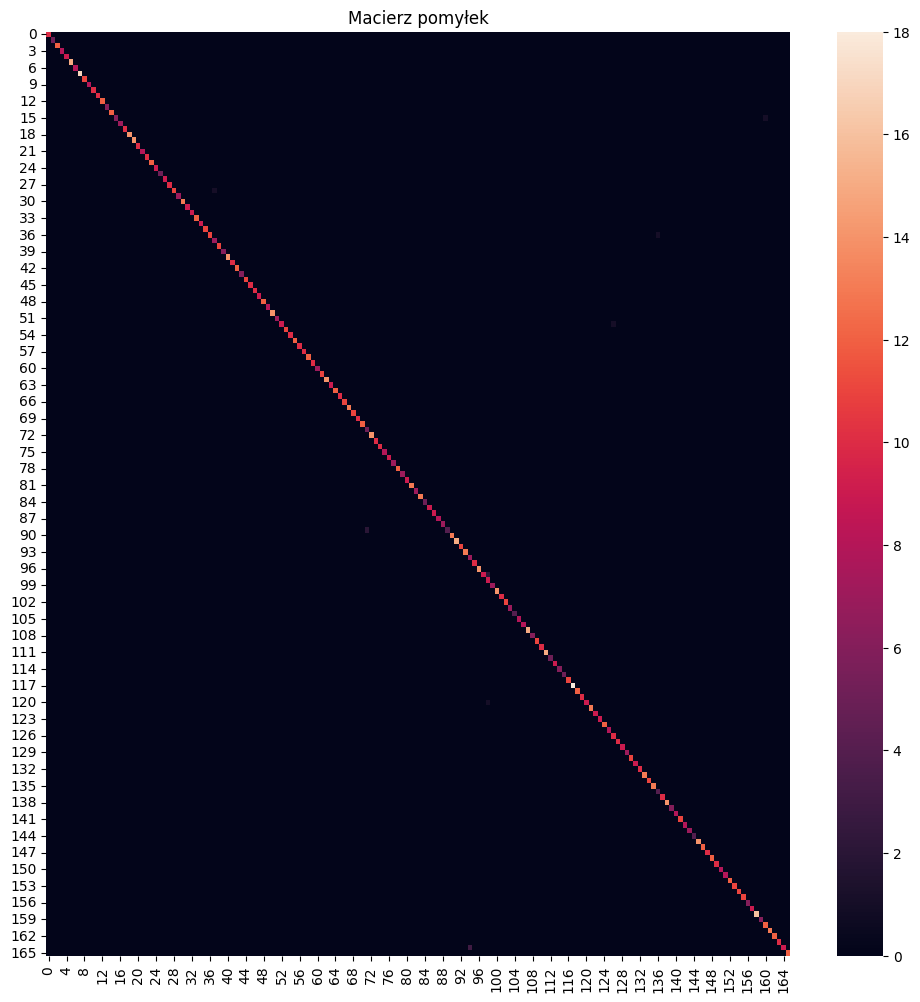

In [119]:
clf = RandomForestClassifier(random_state=42)
plot_confusion_matrix(clf, X_res, y_res)

## Sprawdzenie istotności cech

### Las losowy

In [67]:
clf_dt = RandomForestClassifier(random_state=42)
clf_dt.fit(X_res, y_res)
columns = X_res.columns
dict_ft = {key: np.round(value, 3) for key, value in zip(columns, clf_dt.feature_importances_)}
feature_importance = pd.Series(dict_ft).sort_values(ascending=False)
feature_importance

Total      0.266
Attack     0.131
Speed      0.130
Defense    0.124
Sp. Atk    0.123
HP         0.121
Sp. Def    0.104
dtype: float64

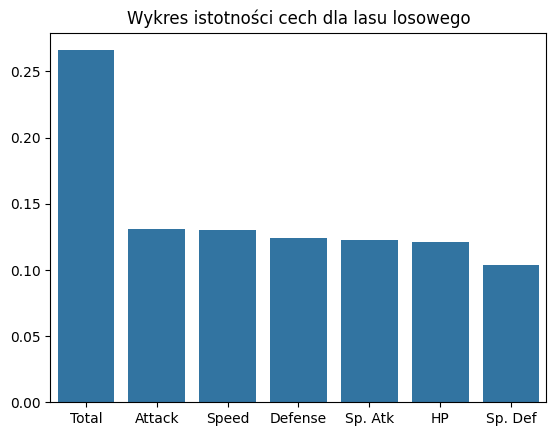

In [68]:
plt.title("Wykres istotności cech dla lasu losowego")
sns.barplot(feature_importance)
plt.show()

In [65]:
clf_rf = RandomForestClassifier(random_state=42)
clf_rf.fit(X_res.drop('Total', axis=1), y_res)
columns = X_res.drop('Total', axis=1).columns
dict_ft = {key: np.round(value, 3) for key, value in zip(columns, clf_rf.feature_importances_)}
feature_importance = pd.Series(dict_ft).sort_values(ascending=False)
feature_importance

Attack     0.180
Speed      0.172
Defense    0.168
Sp. Atk    0.164
HP         0.163
Sp. Def    0.153
dtype: float64

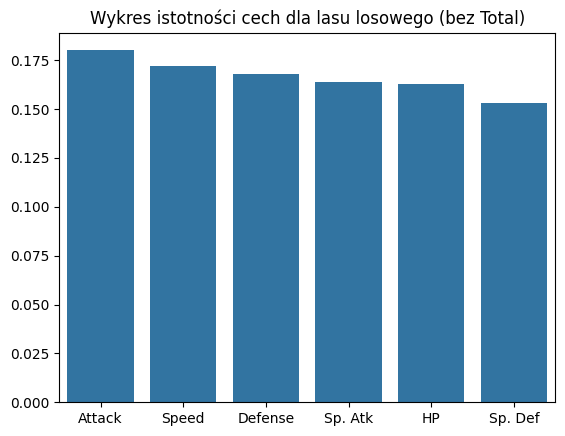

In [66]:
plt.title("Wykres istotności cech dla lasu losowego (bez Total)")
sns.barplot(feature_importance)
plt.show()

### Drzewo decyzyjne

In [70]:
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt.fit(X_res, y_res)
columns = X_res.columns
dict_ft = {key: np.round(value, 3) for key, value in zip(columns, clf_dt.feature_importances_)}
feature_importance = pd.Series(dict_ft).sort_values(ascending=False)
feature_importance

Total      0.467
Sp. Atk    0.117
Defense    0.113
Attack     0.109
Speed      0.074
HP         0.068
Sp. Def    0.053
dtype: float64

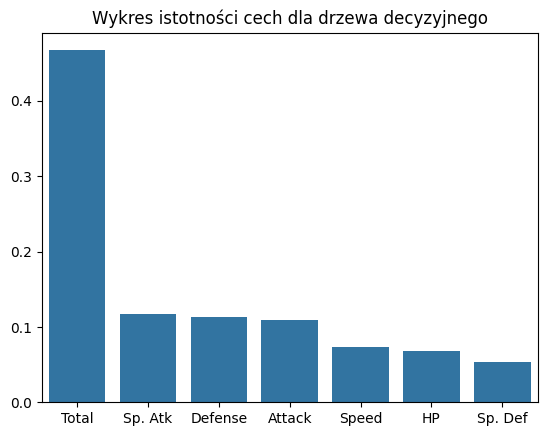

In [71]:
plt.title("Wykres istotności cech dla drzewa decyzyjnego")
sns.barplot(feature_importance)
plt.show()

In [76]:
clf_rf = DecisionTreeClassifier(random_state=42)
clf_rf.fit(X_res.drop('Total', axis=1), y_res)
columns = X_res.drop('Total', axis=1).columns
dict_ft = {key: np.round(value, 3) for key, value in zip(columns, clf_rf.feature_importances_)}
feature_importance = pd.Series(dict_ft).sort_values(ascending=False)
feature_importance

Speed      0.202
Sp. Def    0.176
Attack     0.170
Defense    0.163
HP         0.150
Sp. Atk    0.139
dtype: float64

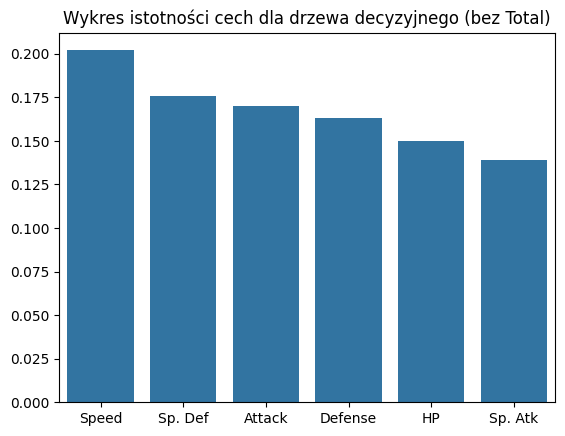

In [77]:
plt.title("Wykres istotności cech dla drzewa decyzyjnego (bez Total)")
sns.barplot(feature_importance)
plt.show()

Obydwa modele "uważają", że najwięcej informacji przenosi zmienna Total. Może być to spowodowane tym, że w sumie składa się ona z innych zmiennych, przez co może przenosić trochę ich informacji. Warto się zastanowić nad tym, czy ta zmienna powinna być brana pod uwagę i czy nie będzie ona zbędna. Chciałbym teraz zweryfikować jak usunięcie cechy Total wpłynie na model. Czy model użyje innych cech i skompensuje brak tej cech czy może nie będzie wstanie tego nadrobić.

### Testowanie wpływu zmiennej Total

In [53]:
clf_rf = RandomForestClassifier(random_state=42)
cv_results = cross_validate(clf_rf, X_res.drop("Total", axis=1), y_res, scoring=("accuracy", "f1_micro"), cv=10)
print(f"Accuracy: {np.round(np.mean(cv_results["test_accuracy"]),3)}")
print(f"F1 score: {np.round(np.mean(cv_results["test_f1_micro"]),3)}")

Accuracy: 0.955
F1 score: 0.955


In [54]:
clf_dt = DecisionTreeClassifier(random_state=42)
cv_results = cross_validate(clf_dt, X_res.drop("Total", axis=1), y_res, scoring=("accuracy", "f1_micro"), cv=10)
print(f"Accuracy: {np.round(np.mean(cv_results["test_accuracy"]),3)}")
print(f"F1 score: {np.round(np.mean(cv_results["test_f1_micro"]),3)}")

Accuracy: 0.866
F1 score: 0.866


Jak można zauważyć usunięcie zmiennej Total spowodowało znaczny spadek dokładności. Szczególnie jest to zauważalne w przypadku drzew decyzyjnych. Natomiast ten wpływ dla drzew decyzyjnych jest większy ponieważ zmienna Total dla drzew jest o wiele ważniejsza (praktycznie dwa razy większa istotność).

### Sprawdzenie istotności innych zmiennych

In [91]:
X_more = df_prepared.drop('Name', axis=1)
y_more = df_prepared.Name

In [92]:
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt.fit(X_more, y_more)
columns = X_more.columns
dict_ft = {key: np.round(value, 3) for key, value in zip(columns, clf_dt.feature_importances_)}
feature_importance = pd.Series(dict_ft).sort_values(ascending=False)
feature_importance

Total         0.425
Type 2        0.134
Type 1        0.127
Speed         0.074
Sp. Atk       0.055
Attack        0.055
HP            0.051
Defense       0.046
Sp. Def       0.034
Generation    0.000
dtype: float64

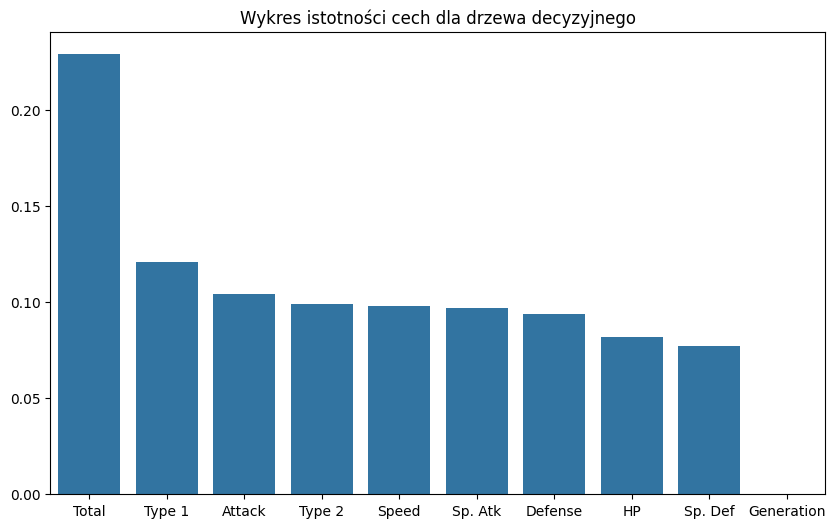

In [89]:
plt.figure(figsize=(10,6))
plt.title("Wykres istotności cech dla drzewa decyzyjnego")
sns.barplot(feature_importance)
plt.show()

In [93]:
clf_dt = DecisionTreeClassifier(random_state=42)
cv_results = cross_validate(clf_dt, X_more.drop("Generation", axis=1), y_more, scoring=("accuracy", "f1_micro"), cv=10)
print(f"Accuracy: {np.round(np.mean(cv_results["test_accuracy"]),3)}")
print(f"F1 score: {np.round(np.mean(cv_results["test_f1_micro"]),3)}")

C:\Users\urbii\Desktop\Projekty\Machine-learning-course\venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


Accuracy: 0.986
F1 score: 0.986


In [90]:
clf_rf = RandomForestClassifier(random_state=42)
clf_rf.fit(X_more, y_more)
columns = X_more.columns
dict_ft = {key: np.round(value, 3) for key, value in zip(columns, clf_rf.feature_importances_)}
feature_importance = pd.Series(dict_ft).sort_values(ascending=False)
feature_importance

Total         0.229
Type 1        0.121
Attack        0.104
Type 2        0.099
Speed         0.098
Sp. Atk       0.097
Defense       0.094
HP            0.082
Sp. Def       0.077
Generation    0.000
dtype: float64

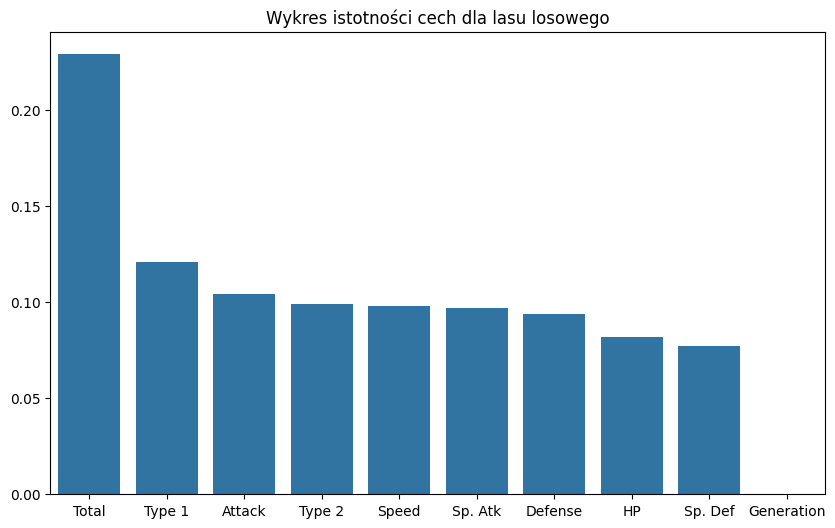

In [85]:
plt.figure(figsize=(10,6))
plt.title("Wykres istotności cech dla lasu losowego")
sns.barplot(feature_importance)
plt.show()

In [94]:
clf_rf = RandomForestClassifier(random_state=42)
cv_results = cross_validate(clf_rf, X_more.drop("Generation", axis=1), y_more, scoring=("accuracy", "f1_micro"), cv=10)
print(f"Accuracy: {np.round(np.mean(cv_results["test_accuracy"]),3)}")
print(f"F1 score: {np.round(np.mean(cv_results["test_f1_micro"]),3)}")

C:\Users\urbii\Desktop\Projekty\Machine-learning-course\venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


Accuracy: 0.998
F1 score: 0.998


Dodanie zmiennych Type I i Type II dodaje dość sporo informacji przez co wynik się znacząco zwiększa. Wydaje się, że dodanie tych zmiennych może być lepsze niż augmentacja danych. Postanowiłem, że wykonam augementację albo dodame te zmienne poniewaz augementacja zmiennych kategorycznych za pomocą SMOTE może być niezbyt dokładna. Dodatkowo zastanawiam się czy powininem użyć dla zmiennych Type I i Type II kodowania ordynalnego, czy też lepiej by było użyć one hot encoding. To drugie na pewno zagwarantowało by, że model jakoś pod spodem dziwnie nie układa sobie tych typów od najlepszego do najgorsze lub jakoś inaczej. Ale można stwierdzić, że wyniki są bardzo zadowolające więc można tak to pozostawić. Model który wybiera jako finalny jest to model lasów losowych, poniewaz od początku otrzymywałem najlepsze wyniki używając tego modelu.

## Przeprowadzenie predykcji na zbiorze testowym

Na początku musiałem wczytać dane testowe. Następnie w taki sam sposób je przetworzyć jak dane treningowe i oczywiście usunąc cechy, które nie będą używane.

In [97]:
df_test = pd.read_csv("https://pwozniak.kia.prz.edu.pl/files/uczeniemaszynowe/test_data.csv")
df_test.head()

,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,Grass,Poison,79,103,119,123,116,85,1,False
1,Fairy,NaN,69,35,53,63,64,39,1,False
2,Water,NaN,39,41,45,43,42,90,1,False
3,Normal,NaN,52,51,46,45,42,52,1,False
4,Water,Fighting,89,93,98,80,87,63,1,False


In [98]:
df_no_nans = df_test.fillna('Other')
df_no_nans.head()

,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,Grass,Poison,79,103,119,123,116,85,1,False
1,Fairy,Other,69,35,53,63,64,39,1,False
2,Water,Other,39,41,45,43,42,90,1,False
3,Normal,Other,52,51,46,45,42,52,1,False
4,Water,Fighting,89,93,98,80,87,63,1,False


In [102]:
df_no_nans["Total"] = df_no_nans["HP"] + df_no_nans["Attack"] + df_no_nans["Defense"] + df_no_nans["Sp. Atk"] + df_no_nans["Sp. Def"] + df_no_nans["Speed"] 

In [103]:
df_clean = df_no_nans[(df_no_nans.HP > 0) & (df_no_nans.Attack > 0) & (df_no_nans.Defense > 0)].reset_index(drop=True)

columns = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
for column in columns:
    print(f"Wiersze w {column} które mają wartość poniżej lub równe 0: {len(df_clean[df_clean[column] <= 0])}")

Wiersze w Total które mają wartość poniżej lub równe 0: 0
Wiersze w HP które mają wartość poniżej lub równe 0: 0
Wiersze w Attack które mają wartość poniżej lub równe 0: 0
Wiersze w Defense które mają wartość poniżej lub równe 0: 0
Wiersze w Sp. Atk które mają wartość poniżej lub równe 0: 0
Wiersze w Sp. Def które mają wartość poniżej lub równe 0: 0
Wiersze w Speed które mają wartość poniżej lub równe 0: 0


In [104]:
label_enc = LabelEncoder()
df_cat = pd.DataFrame()
for column in ['Type 1', 'Type 2']:
    df_cat[column] = label_enc.fit_transform(df_clean[column])

In [109]:
df_num = df_clean[['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']]
minmax_scaler = MinMaxScaler()
columns = df_num.columns
np_num = minmax_scaler.fit_transform(df_num)
df_num_norm = pd.DataFrame(np_num, columns=columns)
df_prepared = pd.concat([df_num_norm, df_cat, df_clean['Generation']], axis=1)
X_test = df_prepared.drop("Generation", axis=1)
X_test

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Type 1,Type 2
0,0.735043,0.307087,0.515152,0.623656,0.597990,0.820312,0.522293,7,9
1,0.218803,0.267717,0.171717,0.268817,0.296482,0.414062,0.229299,3,8
2,0.179487,0.149606,0.202020,0.225806,0.195980,0.242188,0.554140,14,8
3,0.158974,0.200787,0.252525,0.231183,0.206030,0.242188,0.312102,10,8
4,0.538462,0.346457,0.464646,0.510753,0.381910,0.593750,0.382166,14,3
...,...,...,...,...,...,...,...,...,...
2536,0.230769,0.125984,0.126263,0.301075,0.296482,0.281250,0.630573,2,8
2537,0.350427,0.122047,0.207071,0.118280,0.582915,0.500000,0.656051,12,8
2538,0.675214,0.244094,0.287879,0.317204,0.819095,0.687500,0.878981,12,8
2539,0.367521,0.188976,0.388889,0.284946,0.316583,0.445312,0.566879,5,8


Przed treningiem modelu jeszcze raz wywołałem na tych samych danych label encoder, abym mógł do niego mieć dostęp i odwrócić kodowanie zmiennej y.

In [119]:
label_enc = LabelEncoder()
_ = label_enc.fit_transform(df['Name'])

In [113]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_more.drop('Generation', axis=1), y_more)

RandomForestClassifier(random_state=42)

In [114]:
y_pred = rf.predict(X_test)

In [115]:
y_pred

array([154,  23, 118, ...,   4, 121,  27])

In [121]:
y_pred_enc = label_enc.inverse_transform(y_pred)

In [123]:
df_with_pred = pd.DataFrame({'Name': y_pred_enc})

In [126]:
df_with_pred.to_csv('wyniki_klasyfikacji.csv', index=False)

## Ocena jakości modelu na podstawie plików zawierających wartości rzeczywiste oraz przewidywane

In [ ]:
y_pred = pd.read_csv("wyniki_klasyfikacji.csv")
y_test = pd.read_csv("test_wyniki.csv")

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"F1 score: {f1_score(y_test, y_pred, average='micro')}")